***Описание проекта***

Существует проект открытия небольшого кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Инвесторов интересует текущее положение дел на рынке — сможете ли проект снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов.

***Цель работы:***

Подготовить исследование рынка на основе открытых данных о заведениях общественного питания в Москве.

***Задачи работы:***
- Произвести обзор данных и предобработку данных.
- Провести исследовательский анализ данных.
- На основе анализа сделать общий вывод и дать рекомендации о виде заведения, количестве посадочных мест, а также районе расположения.
- Прокомментировать возможность развития сети.
- Подготовить презентацию исследования для инвесторов.

***Структура данных***

*Таблица rest_data:*
- id — идентификатор объекта;
- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.

## Обзор данных

### Загрузка нужных библиотек

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from io import BytesIO
import requests
import warnings
warnings.filterwarnings('ignore')  
pd.set_option('display.float_format', '{:,.2f}'.format)

### Загрузка данных

In [2]:
df = pd.read_csv('/datasets/rest_data.csv')

In [3]:
df.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Посмотрим общую информацию о ДатаФрейме

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


### Предообработка данных

In [5]:
#Посмотрим кол-во пропусков в столбцах
df.isna().sum()

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

In [6]:
#Посмотрим есть ли явные дубликаты в столбцах
df.duplicated().sum()

0

In [7]:
#Посмотрим есть ли дубликаты в столбцах без учета индекса
df_duplicated = df[df[['object_name', 'address', 'object_type','chain', 'number']].duplicated()]
len(df_duplicated)

82

In [8]:
#Удаалим неявные дубликаты
df = df.drop_duplicates(subset=df.columns.difference(['id']))

In [9]:
#Проверим
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15284 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15284 non-null  int64 
 1   object_name  15284 non-null  object
 2   chain        15284 non-null  object
 3   object_type  15284 non-null  object
 4   address      15284 non-null  object
 5   number       15284 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 835.8+ KB


In [10]:
#Посмотрим стиль написания назаваний столбцов
df.columns

Index(['id', 'object_name', 'chain', 'object_type', 'address', 'number'], dtype='object')

In [11]:
#Посмотрим статистические показатели таблицы
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,"15,284.00","119,506.88","73,042.95",838.00,"28,494.50","144,805.50","184,123.00","223,439.00"
number,"15,284.00",59.78,74.84,0.00,14.00,40.00,80.00,"1,700.00"


In [12]:
#Для удобства и чтобы избежать дубликатов привдем содержание столбцов object_name и object_type к нижнему регистру. 
df['object_name'] = df['object_name'].str.lower()
df['object_type'] = df['object_type'].str.lower()

Чтобы корректно, отображались названия на графике, заменим самое длинное на короткое

In [13]:
df['object_type'] = df['object_type'].replace('предприятие быстрого обслуживания', 'фастфуд')

Исходя из сводной таблицы статистических показателей видно, что в столбце number пристуствуют нулевые значения. Посмотрим их процент

In [14]:
len(df.query('number == 0'))

1589

In [15]:
print('Доля ресторанов , где количество посадочных мест равно нулю:', len(df.query('number == 0'))/len(df['number']))

Доля ресторанов , где количество посадочных мест равно нулю: 0.10396493064642763


Почти 10,5 % значений всего датасета с записями, где количество посадочных мест равно нулю. Весьма высокий показатель, изучим что это за заведения.

In [16]:
number_0 = df.query('number == 0')
number_0['object_type'].value_counts()

фастфуд                      690
кафе                         306
закусочная                   182
магазин (отдел кулинарии)    145
кафетерий                    111
буфет                         64
ресторан                      44
бар                           28
столовая                      19
Name: object_type, dtype: int64

In [17]:
number_0.query('object_type=="кафе"').T

,577,802,1148,2750,2995,4985,4987,4988,4989,4991,...,15201,15246,15252,15253,15271,15278,15287,15288,15290,15331
id,149220,142581,155495,152207,156171,157816,157819,157820,157821,157823,...,212776,214867,222677,214872,211210,211218,211416,211205,211204,211208
object_name,кофейня «кофе хаус»,кофе энигма,суши wok,правда кофе,донерок,пунш мастер,лес,кухни кипра,ok food story,maison declaiz,...,теремок,kfc,чайхона №1,чайхона №1,милти,милти,милти,милти,милти,милти
chain,да,нет,да,нет,нет,нет,нет,нет,нет,нет,...,да,да,да,да,да,да,да,да,да,да
object_type,кафе,кафе,кафе,кафе,кафе,кафе,кафе,кафе,кафе,кафе,...,кафе,кафе,кафе,кафе,кафе,кафе,кафе,кафе,кафе,кафе
address,"город Москва, Павелецкая площадь, дом 1А, стро...","город Москва, Овчинниковская набережная, дом 2...","город Москва, Таганская улица, дом 31/22","город Москва, Нижняя Красносельская улица, дом...","город Москва, Кронштадтский бульвар, дом 3, ст...","город Москва, Нижняя Красносельская улица, дом...","город Москва, Нижняя Красносельская улица, дом...","город Москва, Нижняя Красносельская улица, дом...","город Москва, Нижняя Красносельская улица, дом...","город Москва, Нижняя Красносельская улица, дом...",...,"город Москва, поселение Сосенское, Калужское ш...","город Москва, Кутузовский проспект, дом 57","город Москва, Мячковский бульвар, дом 3А","город Москва, Кутузовский проспект, дом 57","город Москва, Колодезный переулок, дом 3","город Москва, Зеленодольская улица, дом 33, ко...","город Москва, Сормовская улица, дом 6","город Москва, Сокольническая площадь, дом 9А","город Москва, улица Стромынка, дом 25, строение 1","город Москва, Дубининская улица, дом 41, строе..."
number,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
number_0.query('object_type=="ресторан"').T

,1873,4490,4491,4492,4493,4501,4502,4503,4504,6113,...,14620,14622,14930,14967,15068,15084,15105,15108,15236,15255
id,79718,152298,152299,152305,152307,152255,152222,152224,152216,27193,...,219165,219037,223189,210764,215755,214843,219032,210192,219130,218284
object_name,макдоналдс,фудмаркет. яшечкина,фудмаркет. грачева,фудмаркет. шапиро,фудмаркет. салпагарова,фудмаркет.швыдкой,фудмаркет.паритова,фудмаркет. рогачикова,фудмаркет. галичкин,максимальный ресторан,...,bokker,пице хат,porto-pomodoro,дейли шеф,суши сет,coffeeshop,бургер кинг,бургер кинг,kfc,marmalato
chain,да,нет,нет,нет,нет,нет,нет,нет,нет,нет,...,нет,нет,нет,нет,да,да,да,да,да,да
object_type,ресторан,ресторан,ресторан,ресторан,ресторан,ресторан,ресторан,ресторан,ресторан,ресторан,...,ресторан,ресторан,ресторан,ресторан,ресторан,ресторан,ресторан,ресторан,ресторан,ресторан
address,"город Москва, поселение Московский, деревня Го...","город Москва, улица Новый Арбат, дом 21","город Москва, улица Новый Арбат, дом 21","город Москва, улица Новый Арбат, дом 21","город Москва, улица Новый Арбат, дом 21","город Москва, улица Новый Арбат, дом 21","город Москва, улица Новый Арбат, дом 21","город Москва, улица Новый Арбат, дом 21","город Москва, улица Новый Арбат, дом 21","город Москва, Профсоюзная улица, дом 61А",...,"город Москва, улица Вавилова, дом 3","город Москва, улица Вавилова, дом 3","город Москва, Ходынский бульвар, дом 4","город Москва, город Московский, улица Хабарова...","город Москва, улица 8 Марта, дом 8, корпус 1","город Москва, Кутузовский проспект, дом 57","город Москва, улица Вавилова, дом 3","город Москва, поселение Московский, Киевское ш...","город Москва, улица Вавилова, дом 3","город Москва, Хорошёвское шоссе, дом 27"
number,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Мы видим, что основную массу с нулевой рассадкой занимают кафе быстрого питания, работающие на вынос, не будем их удалять

Посмотрим весь список названий и оределим какие могут быть возможные дубликаты

In [19]:
df['object_name'].tolist()

['сметана',
 'родник',
 'кафе «академия»',
 'пиццетория',
 'кафе «вишневая метель»',
 'стол. при гоу сош № 1051',
 'брусника',
 'буфет мтуси',
 'кпф семья-1',
 'столовая мтуси',
 'пекарня 24',
 'гогиели',
 'школа 735',
 'алло пицца',
 'гимназия 1542',
 'школа 1011',
 'суши wok',
 'донер кебаб',
 'тануки',
 'американская лаборатория десертов',
 'кафе',
 'кафе уют',
 'долина чайхона',
 'гбоу школа № 1411 (970)',
 'кафетерий',
 "домино'с пицца",
 'рахимкулова т.х.',
 'столовая при гуп объединенный комбинат школьного питания',
 'школа 1444',
 'мархал',
 'готика',
 'гимназия № 1527',
 'кафе «хинкальная»',
 'суши wok',
 'рыба & мясо на углях',
 'кларом',
 'месопотамия',
 'му-му',
 'хлеб насущный',
 'tajj mahal',
 'калифорния дайнер',
 'балалаечная',
 'пиросмани',
 'данкин донатс',
 'вареничная №1',
 'шоколадница',
 'il pizzaiolo',
 'теремок',
 'хлеб насущный',
 'мосбург',
 'эрик рыжий',
 'домашняя снедь',
 'хинкальная',
 'му-му',
 'восточный квартал',
 'почтмейстер',
 'босфор',
 'мастер',
 '

Видим, что есть кавычки в названия у одних, а у других нет - уберем их.

In [20]:
df['object_name'] = df['object_name'].str.replace(r'[«».]*', '')

Также видим, что есть меножество дубликатов, например, макдоналдс и ресторан макдоналдс, kfc и кафе kfc, subway и сабвей.

Для того, чтобы определить у каких заведений прежде всего заменить дубликаты, посмотрим на первые 50 сетей, у кого больше всех заведений.

In [21]:
df['object_name'].value_counts().head(50)

столовая                               321
кафе                                   264
шаурма                                 242
шоколадница                            158
kfc                                    156
макдоналдс                             150
бургер кинг                            137
теремок                                 94
крошка картошка                         90
домино'с пицца                          90
пекарня                                 81
буфет                                   76
милти                                   72
суши wok                                72
папа джонс                              51
додо пицца                              49
школьно-базовая столовая                44
кофе с собой                            44
чайхона №1                              43
донер кебаб                             41
якитория                                38
кафетерий                               38
хинкальная                              38
выпечка    

Напишем функцию duplicat, которая находит подстроку в ячейке и заменяет на новое значение.

In [22]:
def duplicat(duplicates, names):
    for i, k in zip(duplicates, names):
        df.loc[df['object_name'].str.contains(i, case=False), 'object_name'] = k
# подстроки для замены
old_value = ['шоколадница', 'кфс', 'бургер кинг','макдоналдс', 'McDonald', 'теремок', "домино'с пицца", 
       'крошка картошка', 'суши вок', 'суши wok', 'милти', 'папа джонс','додо пицца','старбакс', 'starbucks', 
       'иль патио', 'иль-патио','il патио', 'subway', 'сабвей', 'братьев караваевых', 'братья караваевы', 'якитория', 
       'кофе хаус', 'кофе-хаус', 'баскин роббинс', 'baskin robbins', 'мята lounge', 'мята', 'андерсон', 'му-му',
       'данкин донатс', 'dunkin donuts', 'cofix', 'даблби', 'дабл би', 'тануки', 'стардогs', 'стардогс']
       
new_value = ['шоколадница', 'kfc','бургер кинг', 'макдоналдс', 'макдоналдс', 'теремок', "домино'с пицца", 
       'крошка картошка', 'суши wok', 'суши wok', 'милти', 'папа джонс', 'додо пицца','starbucks', 'starbucks', 
       'il Патио', 'il Патио','il патио','subway', 'subway', 'кулинарная лавка братьев караваевых', 'кулинарная лавка братьев караваевых',
       'якитория', 'кофе хаус', 'кофе хаус', 'baskin robbins', 'baskin robbins', 'мята lounge', 'мята lounge', 'андерсон', 'му-му',
       'dunkin donuts','dunkin donuts','cofix', 'даблби', 'даблби', 'тануки', 'стардогс', 'стардогс']
duplicat(old_value, new_value)

Проверим как изменилось количество заведений в сети

In [23]:
df['object_name'].value_counts().head(15)

столовая           321
кафе               264
шаурма             242
шоколадница        189
макдоналдс         173
бургер кинг        161
kfc                158
теремок            116
домино'с пицца      99
крошка картошка     96
суши wok            91
милти               83
пекарня             81
буфет               76
starbucks           71
Name: object_name, dtype: int64

### Выводы к разделу

- в исходном датафрейме 15366 строк;
- типы данных в столбцах корректны;
- пропусков в данных нет, найдено и удалено 82 дубликата;
- привели содержание столбцов object_name и object_type к нижнему регистру;
- выявили и заменили дубликаты в столбце object_name;
- выявлено, что 10,5 % значений всего датасета это записи, где количество посадочных мест равно нулю. Это кафе быстрого питания, работающие на вынос, принято решение их не удалять.

## Анализ данных

### Соотношение видов объектов общественного питания по количеству

Создадим таблицу с видами объектов общественного питания и их количеством

In [24]:
object_type_group = df.groupby('object_type').agg({'number':'count'}).reset_index()
object_type_group.columns=['object_type','count']
object_type_group = object_type_group.sort_values('count', ascending = False)
display(object_type_group)

,object_type,count
3,кафе,6071
7,столовая,2584
6,ресторан,2282
8,фастфуд,1898
0,бар,855
1,буфет,577
4,кафетерий,395
2,закусочная,349
5,магазин (отдел кулинарии),273


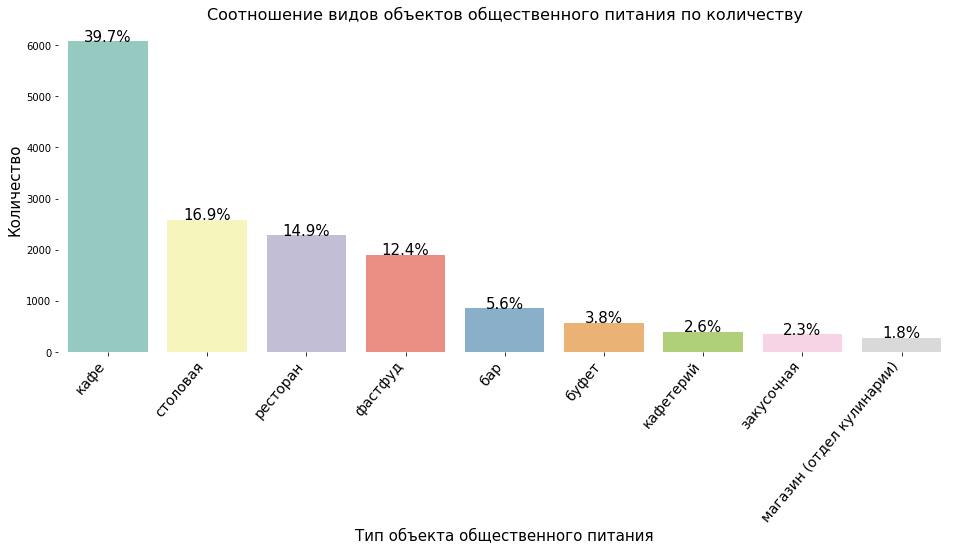

In [25]:
plt.figure(figsize=(16, 6))
ax=sns.barplot(x='object_type', y='count', data = object_type_group, palette = 'Set3')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, horizontalalignment ='right', size=14)
plt.box(False)
plt.grid(False)
total= object_type_group['count'].sum()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1%}'.format(height/total),
            ha="center", size=15) 
plt.title('Cоотношение видов объектов общественного питания по количеству', fontsize=16)
plt.xlabel('Тип объекта общественного питания', fontsize=15)
plt.ylabel('Количество', fontsize=15);

**Вывод:**

По видам объектов общественного питания лидирует кафе - 39.7% (6071 ед.), далее столовая - 16.9% (2584 ед.) и тройку замыкает ресторан (2282 ед.). Меньше всего у магазина(отдела кулинарии) - 1,8% (273 ед.)

### Соотношение сетевых и несетевых заведений по количеству

In [26]:
chain_group = df.groupby('chain')['object_name'].count()
chain_group
display(chain_group)

chain
да      2964
нет    12320
Name: object_name, dtype: int64

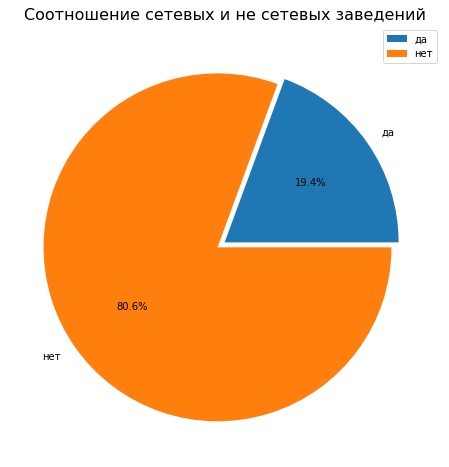

In [27]:
plt.figure(figsize=(10, 8))
ax = chain_group .plot(kind='pie', autopct='%1.1f%%', legend=True, explode =(0,0.05))
ax.set_title('Cоотношение сетевых и не сетевых заведений', fontsize=16)
plt.ylabel('');

**Вывод:**

Несетевых заведений гораздо больше, чем сетевых, 80,6 % против 19,4%.
Несетевых заведений 12320, а сетевых - 2964 ед.

### Для какого вида объекта общественного питания характерно сетевое распространение?

In [28]:
object_type_chain = df.pivot_table(index=['object_type'], columns='chain', values='id', aggfunc='count').reset_index()
object_type_chain.columns = object_type_chain.columns = ['object_type','chain_count','not_chain_count']
display(object_type_chain.sort_values(by='chain_count', ascending=False))

,object_type,chain_count,not_chain_count
3,кафе,1396,4675
8,фастфуд,788,1110
6,ресторан,543,1739
5,магазин (отдел кулинарии),78,195
2,закусочная,56,293
4,кафетерий,52,343
0,бар,37,818
1,буфет,11,566
7,столовая,3,2581


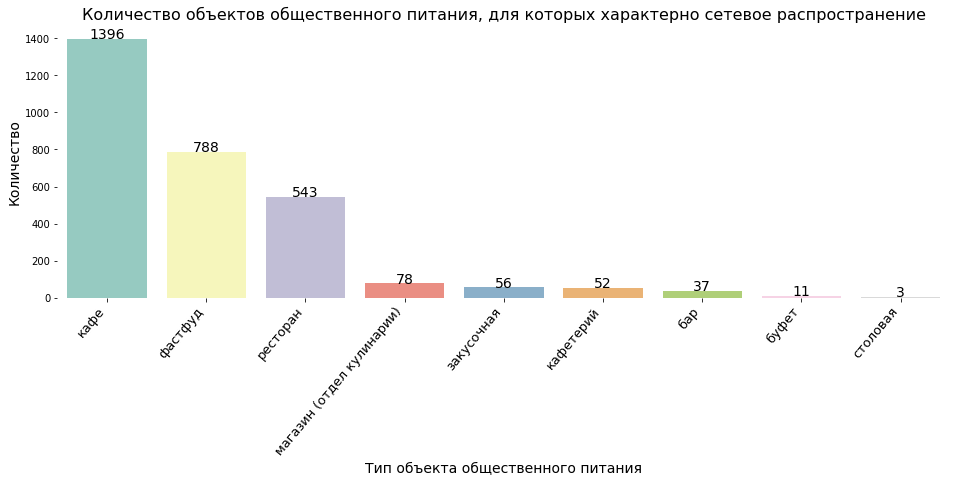

In [29]:
plt.figure(figsize=(16, 5))
ax=sns.barplot(x='object_type', y='chain_count', data = object_type_chain.sort_values(by='chain_count', ascending=False), palette = 'Set3')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, horizontalalignment ='right', size=13)
plt.box(False)
plt.grid(False)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 1,
            '{:.0f}'.format(height),
            ha="center",size=14)
plt.title('Количество объектов общественного питания, для которых характерно сетевое распространение', fontsize=16)
plt.xlabel('Тип объекта общественного питания', fontsize=14)
plt.ylabel('Количество', fontsize=14);

In [30]:
object_type_chain['total_count']=object_type_chain['chain_count']+object_type_chain['not_chain_count']
object_type_chain['chain_rate']=object_type_chain['chain_count']/object_type_chain['total_count']*100

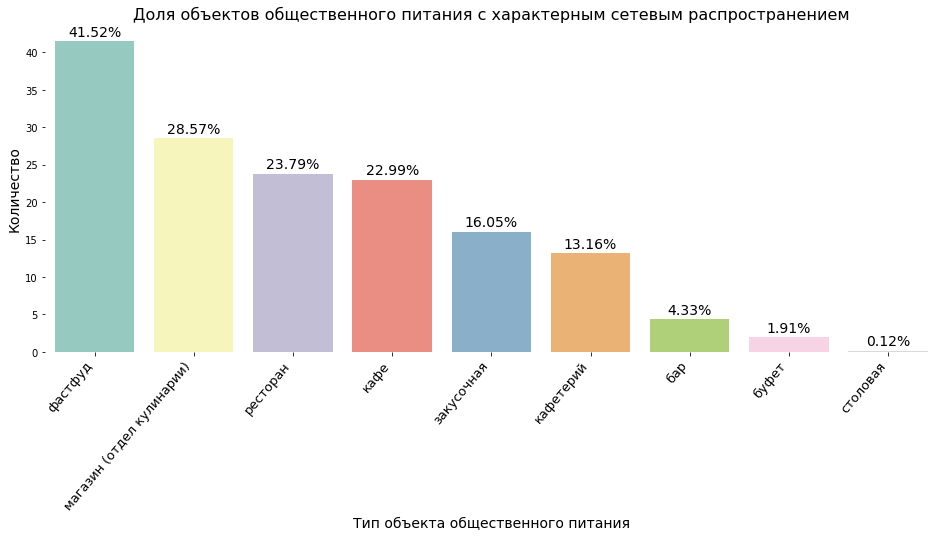

In [31]:
plt.figure(figsize=(16, 6))
ax=sns.barplot(x='object_type', y='chain_rate', data = object_type_chain.sort_values(by='chain_rate', ascending=False),palette = 'Set3')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, horizontalalignment ='right', size=13)
plt.box(False)
plt.grid(False)
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()/100
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, (y + height*100)+.7), ha='center', size=14)
plt.title('Доля объектов общественного питания с характерным сетевым распространением', fontsize=16)
plt.xlabel('Тип объекта общественного питания', fontsize=14)
plt.ylabel('Количество', fontsize=14);

**Вывод:**

В абсолютных значениях больше всего сетевых заведений у кафе - 1396 ед, фастфуд на 2-ом месте - 788 ед., на последнем месте столовая - 3 ед., но если рассматривать отношение сетевых и несетевых заведений в рамках одного вида объекта, то в лидерах фастфуд - 41.52%, в то время как у кафе только 23% всех заведений сетевые.

### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

In [32]:
df_number = df.query('chain == "да"')
df_number_pivot=df_number.pivot_table(
    index='object_name',values=['id','number'], aggfunc={'id':'count','number':'mean'}).reset_index()
df_number_pivot.columns=['object_name','count','number']
df_number_pivot.head(10)

,object_name,count,number
0,baskin robbins,15,10.13
1,beverly hills diner,1,88.00
2,bierloga,1,75.00
3,black & white,1,40.00
4,bocconcino,3,66.67
5,boobo,1,46.00
6,bubbleology,1,6.00
7,burger club,3,20.33
8,coffeeshop,1,0.00
9,coffeeshop company,4,47.25


In [33]:
df_number_pivot.describe().T

,count,mean,std,min,25%,50%,75%,max
count,441.00,6.72,20.32,1.00,1.00,1.00,3.00,185.00
number,441.00,61.69,54.72,0.00,20.00,46.00,87.52,306.00


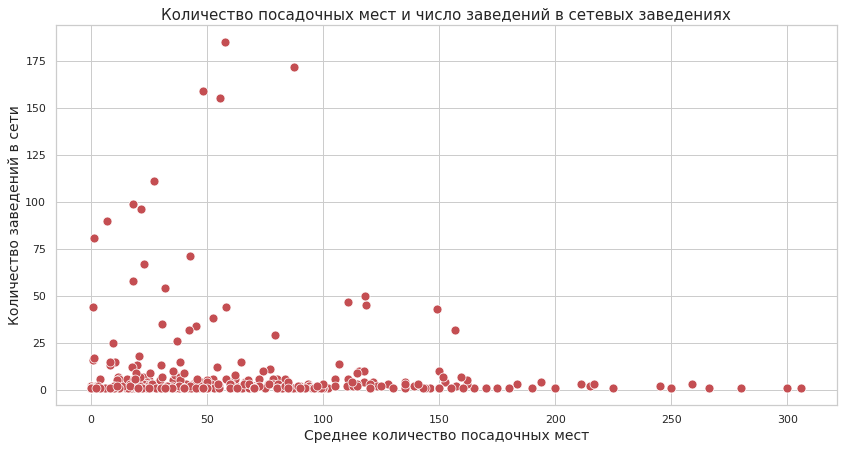

In [34]:
# построим диаграмму рассеивания
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")
sns.scatterplot(data=df_number_pivot, x='number', y='count', color='r', s=80)

plt.title('Количество посадочных мест и число заведений в сетевых заведениях', fontsize=15)
plt.xlabel('Среднее количество посадочных мест', fontsize=14);
plt.ylabel('Количество заведений в сети', fontsize=14);

**Вывод:**

В городе преобладает большее число заведений с малым количеством посадочных мест - до 50 мест (медианное значение - 44), далее плотность распределения идет к резкому уменьшению и практически равна нулю на отметке в 300 посадочных мест.

### Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики.

In [35]:
df_mean_number_pivot=df.pivot_table(
    index='object_type', aggfunc={'number':'mean'}).reset_index()
df_mean_number_pivot.columns=['object_type','mean_number']
display(df_mean_number_pivot)

,object_type,mean_number
0,бар,43.53
1,буфет,51.51
2,закусочная,7.83
3,кафе,39.79
4,кафетерий,9.18
5,магазин (отдел кулинарии),5.59
6,ресторан,96.88
7,столовая,130.34
8,фастфуд,20.81


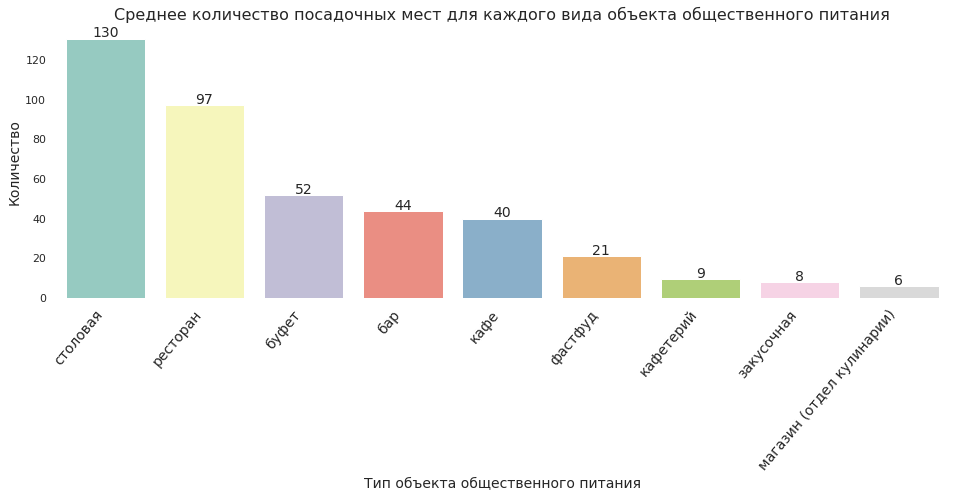

In [36]:
plt.figure(figsize=(16, 5))
ax=sns.barplot(x='object_type', y='mean_number', data = df_mean_number_pivot.sort_values(by='mean_number', ascending=False),palette = 'Set3')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, horizontalalignment ='right', size=14)
plt.box(False)
plt.grid(False)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 1,
            '{:.0f}'.format(height),
            ha="center",size=14)
plt.title('Cреднее количество посадочных мест для каждого вида объекта общественного питания', fontsize=16)
plt.xlabel('Тип объекта общественного питания', fontsize=14)
plt.ylabel('Количество', fontsize=14);

In [37]:
#Что было ранее в проекте

#plt.figure(figsize=(15, 7))
#sns.boxplot(x='object_type', y='number', data=df,palette = 'Set3');
#plt.title('Распределение количества посадочных мест по видам объектов общественного питания', fontsize=15)
#plt.box(False)
#plt.grid(False)
#plt.xlabel('Вид объекта общественного питания', fontsize=14 );
#plt.ylabel('Количество посадочных мест', fontsize=14);
#plt.ylim(0, 500);

**Вывод:**

В среднем самое большое число посадочных мест в столовых (130 места), далее на втором месте ресторанв (97 мест), тройку замыкают буфеты (52 посадочных места). У кафе - в среднем 40 посадочных мест, у фастфуда - 21, меньше всего посадочных мсет у отделов кулинарии - 6.

### Выделите в отдельный столбец информацию об улице из столбца address .

In [38]:
#воспользумся регулярным выражением для извлечения улицы из адреса
words = ['улица','ул','переулок','шоссе','проспект','площадь','проезд',
         'село','аллея','бульвар','набережная','тупик','линия']
str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))
df["street"] = df["address"].str.extract(str_pat, flags=re.I)
df.sample(5)

,id,object_name,chain,object_type,address,number,street
13165,194168,кафе ph&b,нет,кафе,"город Москва, 2-я Звенигородская улица, дом 13...",25,2-я Звенигородская улица
2642,28569,столовая педколледжа №13,нет,столовая,"город Москва, Большая Академическая улица, дом...",240,Большая Академическая улица
8189,129828,ресторан zotman pizza pie,нет,ресторан,"город Москва, Большая Никитская улица, дом 23/...",45,Большая Никитская улица
7286,28351,столовая московский индустриальный банк,нет,столовая,"город Москва, улица Орджоникидзе, дом 5",52,улица Орджоникидзе
9637,164717,теремок,да,кафе,"город Москва, поселение Воскресенское, Чечёрск...",8,Чечёрский проезд


### Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [39]:
top_street=df.pivot_table(
    index='street', aggfunc={'object_type':'count'}).reset_index()
top_street.columns=['street','count']
top_street=top_street.sort_values(by='count', ascending=False).head(10)
display(top_street)

,street,count
1418,проспект Мира,204
1009,Профсоюзная улица,181
683,Ленинградский проспект,170
993,Пресненская набережная,167
397,Варшавское шоссе,164
686,Ленинский проспект,147
1414,проспект Вернадского,128
673,Кутузовский проспект,114
596,Каширское шоссе,111
603,Кировоградская улица,108


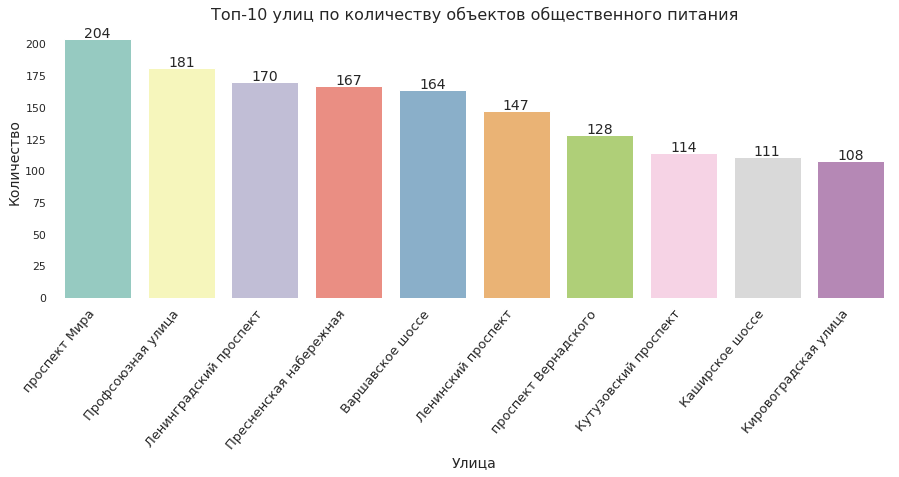

In [40]:
plt.figure(figsize=(15, 5))
ax=sns.barplot(x='street', y='count', data = top_street,palette = 'Set3')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, horizontalalignment ='right', size=13)
plt.box(False)
plt.grid(False)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 1,
            '{:.0f}'.format(height),
            ha="center",size=14)
plt.title('Tоп-10 улиц по количеству объектов общественного питания', fontsize=16)
plt.xlabel('Улица', fontsize=14)
plt.ylabel('Количество', fontsize=14);

Для определения района воспользуемся базой данных из интернета 
https://docs.google.com/spreadsheets/d/1GyKro_Zg5DOgVl42rMJKrH-6ra2Jcuayj4qTlcuM7JI/edit?usp=sharing

In [41]:
spreadsheet_id = "1sguZSB8CeYCbCK2eMmsAlMkz9mBFw11GlyImzqJpjes"
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
data = pd.read_csv(BytesIO(r.content))
data.head()

,street,areaid,okrug,area
0,1-й Автозаводский проезд,98,ЮАО,Даниловский район
1,1-й Амбулаторный проезд,54,САО,Район Аэропорт
2,1-й Архивный переулок,20,ЦАО,Район Хамовники
3,1-й Бабьегородский переулок,21,ЦАО,Район Якиманка
4,1-й Балтийский переулок,54,САО,Район Аэропорт


In [42]:
data.isna().sum()

street    0
areaid    0
okrug     0
area      0
dtype: int64

In [43]:
data.duplicated().sum()

8

In [44]:
data = data.drop_duplicates()

In [45]:
#Найдем районы, в которых расположены эти улицы
top_district = df.groupby('street')['id'].count().sort_values(ascending=False).reset_index().head(10)
top_district = top_district.merge(data, on='street', how='left')
top10 = top_district.pivot_table(index=['street', 'area', 'okrug'], values='id', aggfunc='max')
top10.sort_values(by='id', ascending=False)

id
street                 area                            okrug     
проспект Мира          Ярославский Район               СВАО   204
                       Район Свиблово                  СВАО   204
                       Район Ростокино                 СВАО   204
                       Район Марьина роща              СВАО   204
                       Останкинский район              СВАО   204
                       Мещанский район                 ЦАО    204
                       Алексеевский район              СВАО   204
Профсоюзная улица      Район Коньково                  ЮЗАО   181
                       Академический район             ЮЗАО   181
                       Обручевский район               ЮЗАО   181
                       Район Черемушки                 ЮЗАО   181
                       Район Теплый Стан               ЮЗАО   181
                       Район Ясенево                   ЮЗАО   181
Ленинградский проспект Район Сокол                     САО    170
                       Хорошевский район               САО    170
                       Район Аэропорт                  САО    170
                       Район Беговой                   САО    170
Пресненская набережная Пресненский район               ЦАО    167
Варшавское шоссе       Нагорный район                  ЮАО    164
                       Донской район                   ЮАО    164
                       Район Северное Бутово           ЮЗАО   164
                       Район Южное Бутово              ЮЗАО   164
                       Район Нагатино-Садовники        ЮАО    164
                       Район Чертаново Южное           ЮАО    164
                       Район Чертаново Центральное     ЮАО    164
                       Район Чертаново Северное        ЮАО    164
Ленинский проспект     Район Якиманка                  ЦАО    147
                       Донской район                   ЮАО    147
                       Район Гагаринский               ЮЗАО   147
                       Район Тропарево-Никулино        ЗАО    147
                       Район Теплый Стан               ЮЗАО   147
                       Район Проспект Вернадского      ЗАО    147
                       Обручевский район               ЮЗАО   147
                       Ломоносовский район             ЮЗАО   147
проспект Вернадского   Район Раменки                   ЗАО    128
                       Район Тропарево-Никулино        ЗАО    128
                       Ломоносовский район             ЮЗАО   128
                       Район Гагаринский               ЮЗАО   128
                       Район Проспект Вернадского      ЗАО    128
Кутузовский проспект   Район Фили-Давыдково            ЗАО    114
                       Район Дорогомилово              ЗАО    114
Каширское шоссе        Район Москворечье-Сабурово      ЮАО    111
                       Район Орехово-Борисово Северное ЮАО    111
                       Район Орехово-Борисово Южное    ЮАО    111
                       Район Нагатино-Садовники        ЮАО    111
Кировоградская улица   Район Чертаново Северное        ЮАО    108
                       Район Чертаново Центральное     ЮАО    108
                       Район Чертаново Южное           ЮАО    108

In [46]:
#Найдем районы, в которых расположены эти улицы
top_district = df.groupby('street')['id'].count().sort_values(ascending=False).reset_index()
top_district = top_district.merge(data, on='street', how='left')
top10 = top_district.pivot_table(index=['street', 'area', 'okrug'], values='id', aggfunc='max')
top10.sort_values(by='id', ascending=False)

id
street               area                     okrug     
проспект Мира        Ярославский Район        СВАО   204
                     Останкинский район       СВАО   204
                     Район Свиблово           СВАО   204
                     Алексеевский район       СВАО   204
                     Мещанский район          ЦАО    204
...                                                  ...
улица Гамалеи        Район Щукино             СЗАО     1
Гжатская улица       Можайский Район          ЗАО      1
Гвардейская улица    Можайский Район          ЗАО      1
Гаражная улица       Район Соколиная Гора     ВАО      1
Педагогическая улица Район Бирюлево Восточное ЮАО      1

[2313 rows x 1 columns]

In [47]:
print ('Количество районов через которые проходят улицы с наибольшим количеством заведений: ',top_district['street'].nunique())

Количество районов через которые проходят улицы с наибольшим количеством заведений:  1899


In [48]:
print ('Количество районов через которые проходят улицы с наибольшим количеством заведений: ',df['street'].nunique())

Количество районов через которые проходят улицы с наибольшим количеством заведений:  1899


**Вывод:**

В лидерах по количеству объектов общественного питания улица - проспект Мира (204 заведений), далее следует улица Профсоюзная (181 заведение), тройку замыкает Ленинградский проспект (170 заведений). C точностью до района невозможно определить топ-10 улиц по количеству заведений. Топ 10 улиц очень длинные и проходят сразу по территории нескольких районов.

### Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [49]:
# Посмотрим 10 улиц с самым большим количество заведений
street_one= df.groupby('street').agg({'id': 'nunique'}).sort_values('id', ascending = True)

In [50]:
street_one.head()

,id
street,
Гранатный переулок,1
Малый Путинковский переулок,1
Малый Полуярославский переулок,1
Верхняя улица,1
Малый Николопесковский переулок,1


In [51]:
# Создадим новую таблицу, в которой будет информация только по сетевым заведениям
street_one = street_one.query('id == 1')

In [52]:
district_one = street_one.merge(data['area'], how='left', left_on='street', right_on=data['street'])
district_one.head()

,street,id,area
0,Гранатный переулок,1,Пресненский район
1,Малый Путинковский переулок,1,Тверской район
2,Малый Полуярославский переулок,1,Таганский район
3,Верхняя улица,1,Район Беговой
4,Малый Николопесковский переулок,1,Район Арбат


Проверка на совпадения количества улиц до присоединения и после

In [61]:
print('Количество уникальных улиц до присоединения внешнего источника:', len(street_one))

Количество уникальных улиц до присоединения внешнего источника: 551


In [62]:
print('Количество уникальных улиц до присоединения внешнего источника:', district_one['street'].nunique())

Количество уникальных улиц до присоединения внешнего источника: 551


Количество улиц совпадает

In [55]:
district_one_1 = district_one.groupby(['area'])['street'].count().sort_values(ascending=False).reset_index()
district_one_1.head()

,area,street
0,Таганский район,27
1,Район Хамовники,26
2,Басманный район,25
3,Тверской район,20
4,Пресненский район,19


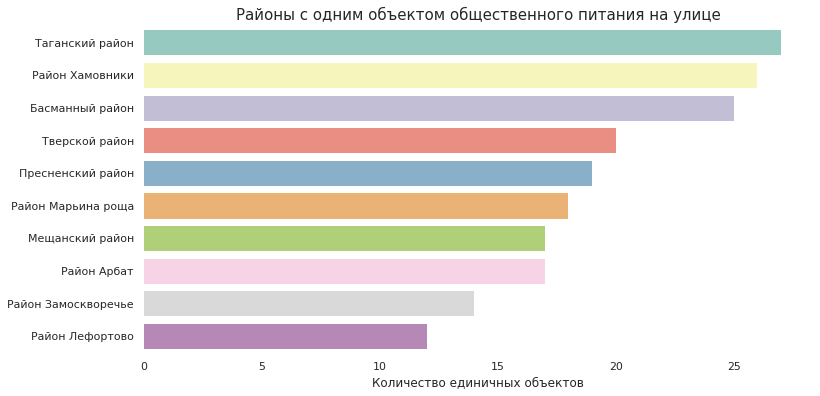

In [56]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='street', y='area', data=district_one_1.head(10),palette = 'Set3')
plt.box(False)
plt.grid(False)
plt.xlabel('Количество единичных объектов')
plt.ylabel('')
plt.title("Районы с одним объектом общественного питания на улице", fontsize='15');

**Вывод:**

Число улиц с одним объектом общественного питания: 551.
Районом лидером среди таких улиц является Таганский район - 27 улиц, далее район Хамовники - 26 улиц, на третьем месте Басманный район - 25 улиц.

Наличие одного объекта обественного питания на улице в данных районах связано с тем, что это - центральные районы и там находятся маленькие переулки/улицы.

### Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?

In [57]:
top_street_seets = (df.groupby(['street']).agg(
    {'id': 'count', 'number': 'mean'})).sort_values(by='id', ascending=False).reset_index()
top_street_seets.head(10)

,street,id,number
0,проспект Мира,204,62.70
1,Профсоюзная улица,181,46.67
2,Ленинградский проспект,170,52.76
3,Пресненская набережная,167,45.84
4,Варшавское шоссе,164,52.48
5,Ленинский проспект,147,63.47
6,проспект Вернадского,128,68.80
7,Кутузовский проспект,114,85.06
8,Каширское шоссе,111,55.50
9,Кировоградская улица,108,59.79


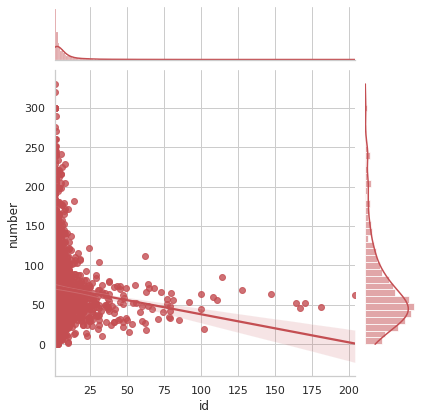

In [58]:
sns.set_palette('muted')
sns.jointplot(x='id', y='number', data=top_street_seets, kind="reg", color='r')
plt.xlabel('Количество объектов общественного питания на улице')
plt.ylabel('Количество посадочных мест')
plt.box(False)
plt.grid(False)

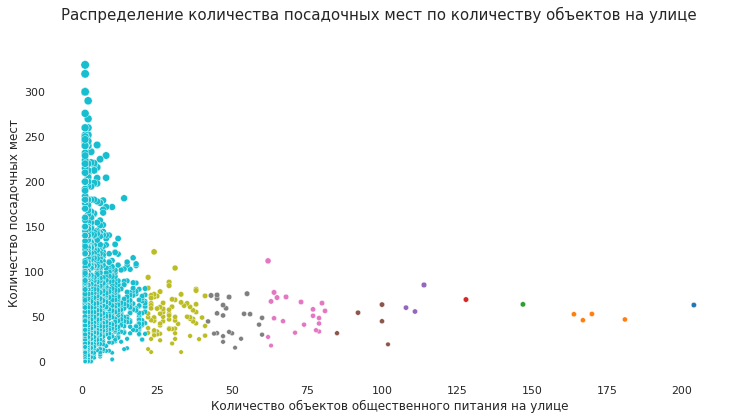

In [59]:
fig = plt.subplots(figsize=(12, 6))
ax2= sns.scatterplot(x='id', y='number', 
                data=top_street_seets, size='number', hue='id', legend=False, 
                palette='tab10_r', alpha=1.0)
plt.xlabel('Количество объектов общественного питания на улице')
plt.ylabel('Количество посадочных мест')
plt.box(False)
plt.grid(False)
plt.suptitle("Распределение количества посадочных мест по количеству объектов на улице", fontsize='15');

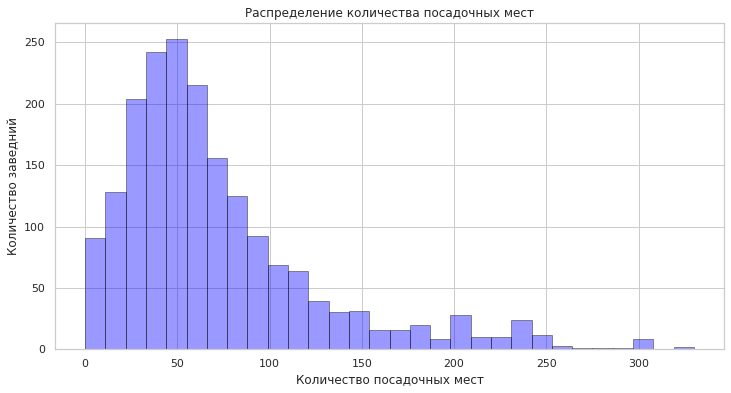

In [60]:
fig = plt.subplots(figsize=(12, 6))
sns.distplot(top_street_seets['number'], hist=True, kde=False, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('Распределение количества посадочных мест')
plt.xlabel('Количество посадочных мест')
plt.ylabel('Количество заведний')
plt.show()

###### Чем больше объектов на улице, тем меньшее количество посадочных мест в заведениях в среднем.
В среднем, на самых "проходных" улицах количество посадочных мест практически одинаково, и оно не превышает 50 мест. Скорее всего это связано с тем, что аренда больших помещений в Москве дорогая.

### Выводы и рекомендации

***Выводы***

Проведя анализ данных рынка объектов общественного питания в г.Москве, мы можем сделать следующие **выводы:**

- По видам объектов общественного питания лидирует кафе - 39.7% (6071 ед.), далее столовая - 16.9% (2584 ед.) и тройку замыкает ресторан (2282 ед.). Меньше всего у магазина(отдела кулинарии) - 1,8% (273 ед.).

- Несетевых заведений гораздо больше, чем сетевых, 80,6 % против 19,4%. Сетевых (2964) заведений примерно в 4 раза меньше, чем не сетевых (12320). 

- В абсолютных значениях больше всего сетевых заведений у кафе - 1396 ед, фастфуд на 2-ом месте - 788 ед., на последнем месте столовая - 3 ед., но если рассматривать отношение сетевых и несетевых заведений в рамках одного вида объекта, то в лидерах фастфуд - 41.52%, в то время как у кафе только 23% всех заведений сетевые.

- В городе преобладает большее число заведений с малым количеством посадочных мест - до 50 мест (медианное значение - 44), далее плотность распределения идет к резкому уменьшению и практически равна нулю на отметке в 300 посадочных мест.

- В среднем самое большое число посадочных мест в столовых (130 места), далее на втором месте рестораны (97 мест), тройку замыкают буфеты (52 посадочных места). У кафе - в среднем 40 посадочных мест, у фастфуда - 21, меньше всего посадочных мест у отделов кулинарии - 6.

- В лидерах по количеству объектов общественного питания улица - проспект Мира (204 заведений), далее следует улица Профсоюзная (181 заведение), тройку замыкает Ленинградский проспект (170 заведений). C точностью до района невозможно определить топ-10 улиц по количеству заведений. Топ 10 улиц очень длинные и проходят сразу по территории нескольких районов.

- Число улиц с одним объектом общественного питания: 551. Районом лидером среди таких улиц является Таганский район - 27 улиц, далее район Хамовники - 26 улиц, на третьем месте Басманный район - 25 улиц.

- Чем больше объектов на улице, тем меньшее количество посадочных мест в заведениях в среднем. В среднем, на самых "проходных" улицах количество посадочных мест практически одинаково, и оно не превышает 50 мест. Скорее всего это связано с тем, что аренда больших помещений в Москве дорого.

***Рекомендации:***

1. Приоритетный вид объекта общественного питания - кафе. 
2. Так как коцепция планируемого кафе уникальная на рынке, то для начала лучше сделать его несетевым, это подчеркнет его уникальность.
2. Количество посадочных мест - 40-50. Это всреднее число подадочных мест для объектов типа "кафе" по Москве.
3. Районы расположения - Таганский, Хамовники, Басманый,Тверской. Так как там больше всего улиц с одним объектом общественного питания, будет меньше конкуренции, но проходимость высокая, так как вмэтих районах скрнцентрированы бизнес-центры, торговые центры и достопримечательности.На таких улицах как Проспект мира, Профсоюзная, Ленинградский проспект скорее всего лучше не открывать заведение, так как там будет высокая конкуренция и высокая стоимость аренды помещения, что для нового объекта, тем более с уникальныой концепцией на рынке чревета увеличением времени по окупаемости проекта.

##  Подготовка презентации

Презентация: https://drive.google.com/file/d/1IVwnjV-PBG8X71rrtBc7XJV0FJnXLt84/view?usp=sharing